# H&M Personalised Fashion Recommender

Part 1: Exploratory Data Analysis <br>
Part 2: Content-Based Filtering Recommender <br>
Part 3: Collaborative Filtering Recommender  <br>
**Part 4: Model Deployment** <br>

## 1. Local Model Deployment with Flask

In [4]:
%%writefile ../streamlit/recommender_app.py 

#########################
##  Import and Set Up  ##
#########################
import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'
from flask import Flask, request
import pandas as pd
from sentence_transformers import SentenceTransformer # For embeddings generation
from sklearn.metrics.pairwise import cosine_similarity # For cosine similarity
from PIL import Image # For loading image
import nmslib # For approximate neareast neighbor search
import pickle

# Instantiate the Flask API with name 'ModelEndpoint'
api = Flask('ModelEndpoint')

##################################
##    Load Content-Based Model  ##
##################################
# Read embeddings data
image_data = pd.read_pickle('../datasets/image_embeddings_merged.pkl')

# Load CLIP model for embedding generation
clip_model = SentenceTransformer('clip-ViT-B-32')

##########################################
##  Load Collaborative Filtering Model  ##
##########################################
# 1. Load the model without indexes
implicit_model = pickle.load(open('../streamlit/collaborative_filtering_model', 'rb'))
# 2. Load indexes
recommend_index = nmslib.init(method="hnsw", space="cosinesimil")
recommend_index.loadIndex(filename='../streamlit/search_index', load_data=True)
similar_items_index = nmslib.init(method="hnsw", space="cosinesimil")
similar_items_index.loadIndex(filename='../streamlit/similar_item_index', load_data=True)
# 3. Set indexes
implicit_model.recommend_index = recommend_index
implicit_model.similar_items_index = similar_items_index
print('implicit model success')

#########################
##      Route 1        ##
#########################
# Home Route - Health check. Just return success if the API is running
@api.route('/') 
def home(): 
    return {"message": "Hello!", "success": True}, 200

#########################
##      Route 2        ##
#########################
# Text Query Recommender
@api.route('/text_query_recommender', methods = ['POST'])

def text_query_recommender():
    user_input = request.get_json(force=True)
    df_schema = {"search_words":str}
    user_input_df = pd.read_json(user_input, lines=True, dtype=df_schema) # Read the file as json object per line
    
    # Encode the text using CLIP
    text_emb = clip_model.encode(user_input_df["search_words"])
    
    # Calculate cosine similarities for queried product
    similarities = cosine_similarity(text_emb,image_data['clip_embedding'].values.tolist())[0]
    
    # Sort cosine similarities in descending order, and select the top 6 recommended products
    similarities = pd.DataFrame(similarities,index=image_data['article_id'], columns=['cosine_sim']).sort_values(by='cosine_sim',ascending=False).iloc[:6]
    
    # Get descriptions of top 6 recommended products from image_data
    nearest_articles_id = similarities.index.tolist()
    recommended_products = image_data[image_data['article_id'].isin(nearest_articles_id)]
    recommended_products = pd.merge(recommended_products,similarities,on='article_id').sort_values(by='cosine_sim',ascending=False).reset_index().to_dict()
    return recommended_products

#########################
##      Route 3        ##
#########################
# Image Query Recommender
@api.route('/image_query_recommender', methods = ['POST'])

def image_query_recommender():
    # Read the image - binary
    # https://stackoverflow.com/questions/65266569/how-can-i-open-an-image-of-filestorage-type-in-pillow
    file = request.files['image']
    img = Image.open(file).convert('RGB')
    
    # Encode the image using CLIP
    image_emb = clip_model.encode([img])
    
    # Calculate cosine similarities for queried product
    similarities = cosine_similarity(image_emb,image_data['clip_embedding'].values.tolist())[0]
    
    # Sort cosine similarities in descending order, and select the top 6 recommended products
    similarities = pd.DataFrame(similarities,index=image_data['article_id'], columns=['cosine_sim']).sort_values(by='cosine_sim',ascending=False).iloc[:6]
    
    # Get descriptions of top 6 recommended products from image_data
    nearest_articles_id = similarities.index.tolist()
    recommended_products = image_data[image_data['article_id'].isin(nearest_articles_id)]
    recommended_products = pd.merge(recommended_products,similarities,on='article_id').sort_values(by='cosine_sim',ascending=False).reset_index().to_dict()
    
    return recommended_products

#########################
##      Route 4        ##
#########################
@api.route('/show_sampled_products',methods=['POST'])

def show_random_products():
    sampled_products = image_data.dropna(subset='article').head(14).reset_index().to_dict()
    return sampled_products

#########################
##      Route 5        ##
#########################
# Collaborative Filtering
@api.route('/collaborative_filtering',methods=['POST'])

def item_index_recommender():
    user_input = request.get_json(force=True)
    df_schema = {"item_index":int}
    user_input_df = pd.read_json(user_input, lines=True, dtype=df_schema) # Read the file as json object per line
    user_input_index = user_input_df['item_index'][0]
    
    similar_df = pd.DataFrame(implicit_model.similar_items(user_input_index, 6)).T
    similar_df.columns = ['article','cosine_sim']
    recommended_products = image_data[image_data['article'].isin(similar_df['article'])]
    recommended_products = pd.merge(recommended_products,similar_df,on='article').sort_values(by='cosine_sim',ascending=False).iloc[1:].reset_index().to_dict()
    
    return recommended_products
    
#########################
##     Run the API     ##
#########################
if __name__ == '__main__': 
    api.run(host='0.0.0.0', 
            debug=True,
            port=int(os.environ.get("PORT", 8080)) 
           )

Overwriting ../streamlit/recommender_app.py


**Notes on request.files**
- request.files['image'] -> Create a FileStorage for uploaded file. Can apply .seek on FileStorage
- request.files['image'].stream -> tempfile.SpooledTemporaryFile object
- request.files['image'].read() -> bytes object.
- request.files.get['image'] -> method object is not subscriptable

## 2. Local Test Run

In [9]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import pickle
from PIL import Image
import requests
import matplotlib.pyplot as plt
import nmslib

### Test Route 2: Text Query Recommender

In [25]:
# Set a user input
user_input_df = pd.DataFrame({"search_words":['sunset']})
user_input = user_input_df.to_json(orient="records", lines=True) # convert df to JSONL (based on link shared earlier)
user_input # confirms successful conversion from Dataframe to JSONL

'{"search_words":"sunset"}\n'

In [26]:
# Route to send request to
api_url = 'http://localhost:8080' 
api_route = '/text_query_recommender'

# Send user_input and receive response
response = requests.post(f'{api_url}{api_route}', json=user_input)
recommended_products = response.json()

### Test Route 3: Image Query Recommender

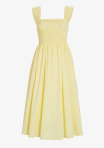

In [160]:
# Set a user input - image read as binary
image_file = {'image':open('../datasets/test_images/test_image_1.png','rb')}
Image.open('../datasets/test_images/test_image_1.png').reduce(4)

In [28]:
# Route to send request to
api_url = 'http://localhost:8080' 
api_route = '/image_query_recommender'

# Send test image and receive response
response = requests.post(f'{api_url}{api_route}', files=image_file)
recommended_products = response.json()

/var/folders/t3/8nf6b8z946b831z2hkj3fdkw0000gn/T/ipykernel_25324/49561499.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, len(recommended_products['img_path']), i)


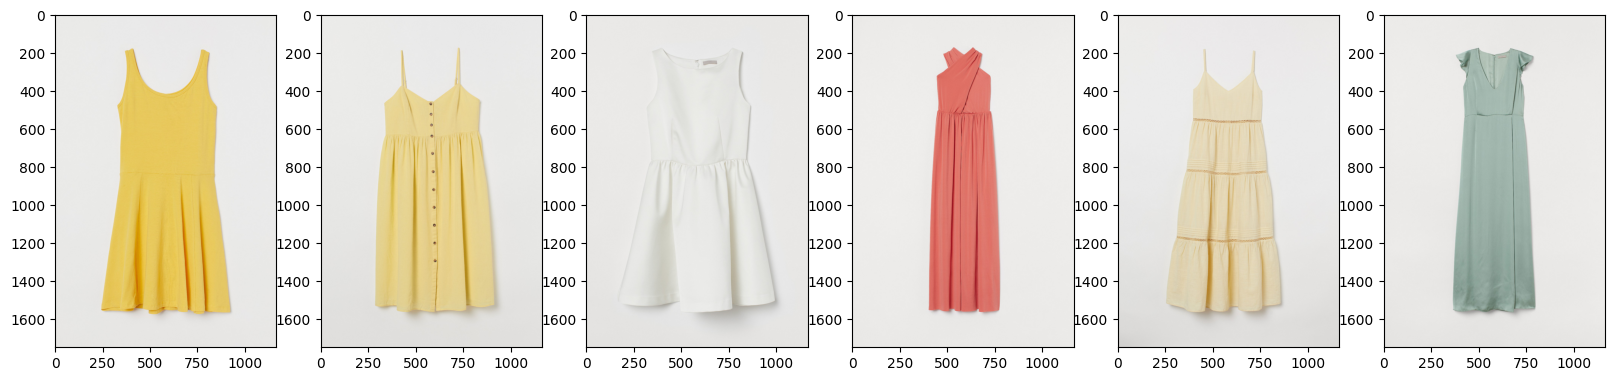

In [29]:
# View the recommended_products
f, ax = plt.subplots(figsize=(20,5))
i = 1
for index, path in recommended_products['img_path'].items():
    plt.subplot(1, len(recommended_products['img_path']), i)
    img = Image.open(path)
    plt.imshow(img)
    i+=1

### Test Route 4: Collaborative Filtering

In [56]:
# Set a user input
user_input_df = pd.DataFrame({"item_index":[200]})
user_input = user_input_df.to_json(orient="records", lines=True) # convert df to JSONL (based on link shared earlier)
user_input # confirms successful conversion from Dataframe to JSONL

'{"item_index":200}\n'

In [65]:
# Route to send request to
api_url = 'http://localhost:8080' 
api_route = '/collaborative_filtering'

# Send request
response = requests.post(f'{api_url}{api_route}', json=user_input)
recommended_products = response.json()

## 3. Streamlit UI

In [69]:
# # 1. Library for cropping image
# # https://github.com/turner-anderson/streamlit-cropper
# !pip install streamlit-cropper

# # 2. Library for selecting images
# # https://github.com/jrieke/streamlit-image-select
# !pip install streamlit-image-select

In [5]:
%%writefile ../streamlit/streamlit_app.py
import streamlit as st
import requests
import json
from PIL import Image
from io import BytesIO

from streamlit_cropper import st_cropper
from streamlit_image_select import image_select

#########################
##        Setup        ##
#########################

# Title and layout of the webpage
st.set_page_config(layout="wide", initial_sidebar_state='expanded')
st.title("H&M Fashion Products Recommender")
st.sidebar.info("Get started by choosing ONE way to search for products, and we would recommend H&M products that you may interested in.")

# Side Bar - Select Page
page_selection = st.sidebar.radio(
    'Search by:',
    ('📚 Keywords', '🖼️ Uploading a Photo', '📸 Taking a Photo', '👀 Browsing Products'))

# Set api url
api_url = 'http://localhost:8080'

# Function to Format Recommender Output
def render_recommended_products():
    # Get response from server
    recommended_products = response.json()
    st.header('Recommended Products')

    # Display top 4 recommended products in 4 columns
    cols = st.columns(4)
    for index, col in enumerate(cols):
        with col:
            index_str = str(index)
            img = Image.open(recommended_products['img_path'][index_str])
            st.image(img)
            st.caption(f"Similarity Score: {round(recommended_products['cosine_sim'][index_str]*100,0)}/100")

            # An expandable description box
            with st.expander("Description"):
                st.write(f"Article ID: {recommended_products['article_id'][index_str]}")
                st.write(f"{recommended_products['detail_desc'][index_str]}")
                link = f"[Product Link](https://www2.hm.com/en_sg/productpage.0{recommended_products['article_id'][index_str]}.html)"
                st.markdown(link, unsafe_allow_html=True)

#########################
##  Search by Keywords ##
#########################
if page_selection == '📚 Keywords':
    cols = st.columns(3)
    
    # Form for user input
    with cols[0]:
        with st.form(key='text_search'):
            search_words = st.text_input("📚 Enter Keywords", placeholder='floral dress',help='Key in the search words to search relevant items here') 
            submit_text = st.form_submit_button(label='Search by Keywords')
    
    # Output
    if submit_text:
        with st.spinner('✨Searching relevant products for you...✨'):    
            # Route to send request to
            api_route = '/text_query_recommender' 
            
            # Request
            user_input = {"search_words":search_words}
            response = requests.post(f'{api_url}{api_route}', json=json.dumps(user_input))
            render_recommended_products()

#########################
##     Upload Image    ##
#########################
if page_selection == '🖼️ Uploading a Photo':
    
    cols = st.columns(3)
    
    # Form for user input
    with cols[0]:
        st.subheader("🖼️ Upload a Photo")
        with st.form(key='upload_file'):
            uploaded_file = st.file_uploader("Upload a Photo", type=['jpg','png','jpeg'])
            submit_uploaded_file = st.form_submit_button(label='Search by Image')
    
    if submit_uploaded_file:
        with cols[1]:
            st.subheader('Uploaded Photo')
            st.image(Image.open(uploaded_file),width=200)
        with st.spinner('✨Searching relevant products for you...✨'): 
            # Route to send request to
            api_route = '/image_query_recommender' 
            # Request
            image_file = {'image':uploaded_file.getvalue()} # Getvalue: read file as bytes
            response = requests.post(f'{api_url}{api_route}', files=image_file)
            render_recommended_products()
            
#########################
##      Take Photo     ##
#########################        
if page_selection == '📸 Taking a Photo':
    cols = st.columns(4)
    
    # User input
    with cols[0]:
        st.subheader("📸 Take a Photo")
        taken_picture = st.camera_input("Take a Photo Here")
    
    # Crop the image
    if taken_picture:
        with cols[1]:
            st.subheader("Crop the Image ")
            cropped_img = st_cropper(Image.open(taken_picture), realtime_update=True, box_color='#000000', aspect_ratio=None, return_type='image')
            st.caption("Crop out the item you are searching for to reduce background noise and improve search accuracy")
        with cols[2]:
            st.subheader("Preview of Cropped Image")
            _ = cropped_img.thumbnail((150,150))
            st.image(cropped_img)
        submit_cropped_image = st.button('Search by Photo')
        
        # Output using cropped image
        if submit_cropped_image:
            with st.spinner('✨Searching relevant products for you...✨'): 
            
                # Route to send request to
                api_route = '/image_query_recommender' 
                
                # Convert cropped image to byte array - https://stackoverflow.com/questions/33101935/convert-pil-image-to-byte-array
                img_byte = BytesIO()
                cropped_img.save(img_byte,format='PNG')
                image_file = {'image':img_byte.getvalue()} # Getvalue: read file as bytes

                # Request
                response = requests.post(f'{api_url}{api_route}', files=image_file)
                render_recommended_products()

#########################
##   Browse Products   ##
#########################
if page_selection == '👀 Browsing Products':
    # Route to send request to
    api_route = '/show_sampled_products'

    # Request
    response = requests.post(f'{api_url}{api_route}')
    sampled_products = response.json()

    # Display 4 sampled products
    images = []
    for index in range(14):
        index_str = str(index)
        img = Image.open(sampled_products['img_path'][index_str])
        images.append(img)

    st.header('Product Gallery')
    product_gallery = image_select(
        label = "Select a product, and find out what people with similar preference usually buy!",
        images = images)

    submit_selected_product = st.button("Search by Selected Product")

    if submit_selected_product:
        index_str = str(images.index(product_gallery))
        article_index = sampled_products['article'][index_str]

        # Route to send request to
        api_route = '/collaborative_filtering' 

        # Request
        user_input = {"item_index":article_index}
        response = requests.post(f'{api_url}{api_route}', json=json.dumps(user_input))
        render_recommended_products()

Overwriting ../streamlit/streamlit_app.py
